# Modeling road networks

Starting convergence for N_mst=500 with target node count=1000
Iteration 1: p_1=0.2320, p_2=0.5540, p_3=0.2000, p_4=0.0140, Node Count=500
Added edge ((33, 1), (32, 1)) to increase p_4
Added edge ((1, 35), (0, 35)) to increase p_3
Iteration 2: p_1=0.2351, p_2=0.5498, p_3=0.1992, p_4=0.0159, Node Count=502
Added edge ((25, 39), (24, 39)) to increase p_4
Added edge ((42, 28), (41, 28)) to increase p_3
Iteration 3: p_1=0.2381, p_2=0.5456, p_3=0.1984, p_4=0.0179, Node Count=504
Added edge ((16, 39), (15, 39)) to increase p_4
Added edge ((40, 12), (39, 12)) to increase p_3
Iteration 4: p_1=0.2411, p_2=0.5415, p_3=0.1976, p_4=0.0198, Node Count=506
Added edge ((35, 38), (34, 38)) to increase p_4
Added edge ((31, 2), (30, 2)) to increase p_3
Iteration 5: p_1=0.2441, p_2=0.5374, p_3=0.1969, p_4=0.0217, Node Count=508
Added edge ((18, 20), (17, 20)) to increase p_4
Added edge ((25, 14), (24, 14)) to increase p_3
Iteration 6: p_1=0.2471, p_2=0.5333, p_3=0.1961, p_4=0.0235, Node Count=510
Added e

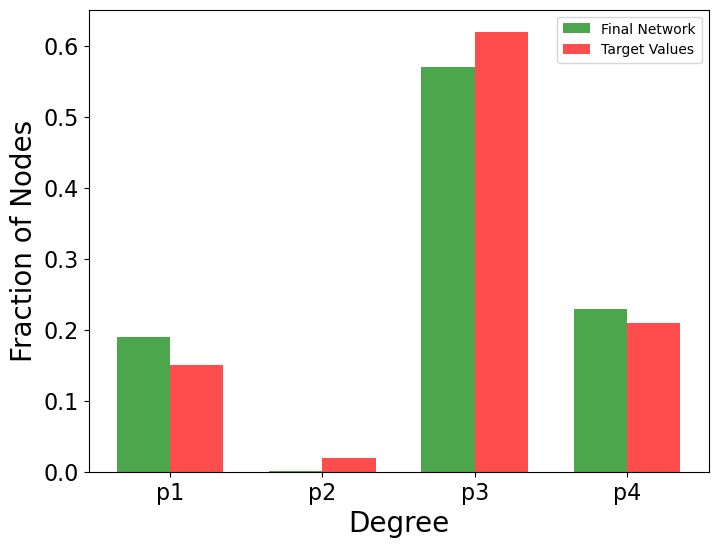

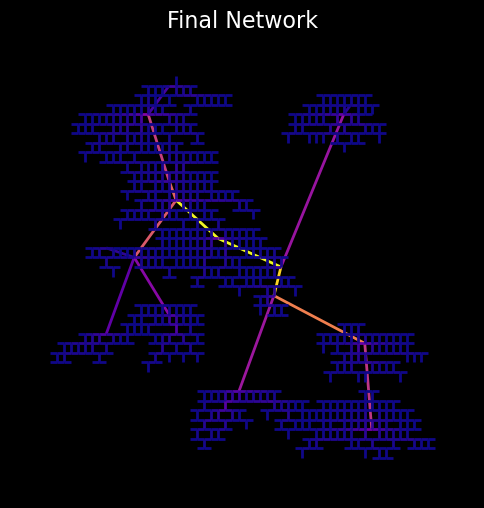

Gini Coefficient of Betweenness Centrality (Final Network on Grid): 0.6333
Effective fraction of nodes (p_eff): 0.4505
Final Optimized Network:


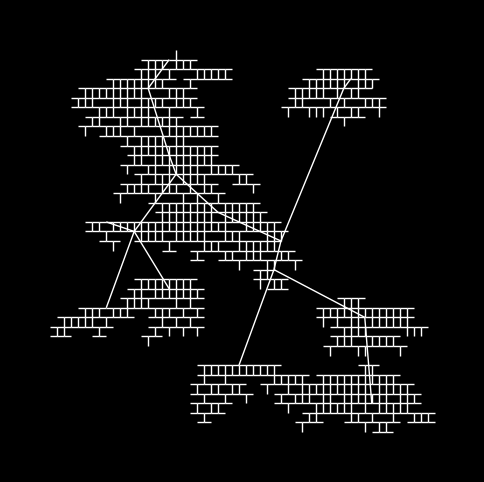

Number of nodes in the Final Optimized Network: 901


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib.cm as cm
import random
from scipy.spatial import distance_matrix

# Function to create a connected component and MST for initial setup
def create_connected_component_random(N_mst, grid_points):
    random_points = random.sample(grid_points, N_mst)
    G = nx.Graph()
    for i, point in enumerate(random_points):
        G.add_node(i, pos=point)

    positions = np.array([G.nodes[i]['pos'] for i in G.nodes()])
    dist_matrix = distance_matrix(positions, positions)

    for i in range(N_mst):
        for j in range(i + 1, N_mst):
            G.add_edge(i, j, weight=dist_matrix[i, j])

    mst = nx.minimum_spanning_tree(G)
    return mst, random_points

# Function to compute degree statistics
def compute_degree_stats(G):
    degrees = dict(G.degree())
    degree_count = {k: 0 for k in range(1, 5)}
    for degree in degrees.values():
        if degree in degree_count:
            degree_count[degree] += 1
    total_nodes = G.number_of_nodes()
    degree_fractions = {k: degree_count[k] / total_nodes for k in range(1, 5)}
    return degree_fractions

# Function to compute Gini coefficient
def gini_coefficient(x):
    x = np.array(x)
    sorted_x = np.sort(x)
    n = len(x)
    gini = (2 * np.sum((np.arange(1, n+1) * sorted_x)) / (n * np.sum(sorted_x))) - (n + 1) / n
    return gini

# Plotting functions
def plot_grid_graph(G, pos, title=''):
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    nx.draw_networkx(G, pos, node_size=0, node_color='lightgreen', edge_color="w", width=1.0, with_labels=False, ax=ax)
    ax.set_axis_off()
    plt.title(title, fontsize=16, color='white')
    plt.show()

def plot_grid_graph_with_betweenness(G, pos, title=''):
    edge_betweenness = nx.edge_betweenness_centrality(G, normalized=True)
    edge_colors = [edge_betweenness[edge] for edge in G.edges()]
    cmap = plt.cm.plasma
    norm = colors.Normalize(vmin=min(edge_colors), vmax=max(edge_colors))

    fig, ax = plt.subplots(figsize=(6, 6))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=cmap, edge_vmin=min(edge_colors), edge_vmax=max(edge_colors), width=2, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_size=0, node_color='lightgreen', ax=ax)
    ax.set_axis_off()

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    plt.title(title, fontsize=16, color='white')
    plt.show()

    return edge_betweenness

# Main function to optimize the network, introducing N_mst iteration loop with flexible adjustment
def optimize_network(p, N_0, N_mst_init, p_t1, p_t2, p_t3, p_t4, tolerance, size_tolerance, max_iterations=10000):
    grid_side = int(N_0 ** 0.5)
    grid_points = [(x, y) for x in range(grid_side) for y in range(grid_side)]
    target_nodes = int(p * N_0)
    N_mst_step = grid_side  # Initial step size for N_mst

    # Start the loop with the initial value of N_mst and adjust it as needed
    N_mst = N_mst_init
    while N_mst > 0 and N_mst < N_0:
        # Create MST and map it to the grid
        G_mst, random_points = create_connected_component_random(N_mst, grid_points)
        grid_MST = nx.Graph()
        for u, v in G_mst.edges():
            grid_MST.add_edge(random_points[u], random_points[v])
        
        # Set the 'pos' attribute in grid_MST for all nodes
        for i, pos in enumerate(random_points):
            grid_MST.nodes[pos]['pos'] = pos
        
        print(f"Starting convergence for N_mst={N_mst} with target node count={target_nodes}")
        
        # Initialize previous degree fractions to detect changes
        previous_p1, previous_p2, previous_p3, previous_p4 = 0, 0, 0, 0
        
        # Begin adjusting degrees p_4, p_3, p_1, etc.
        for iteration in range(max_iterations):
            degree_fractions = compute_degree_stats(grid_MST)
            current_p1, current_p2 = degree_fractions.get(1, 0), degree_fractions.get(2, 0)
            current_p3, current_p4 = degree_fractions.get(3, 0), degree_fractions.get(4, 0)
            num_nodes = grid_MST.number_of_nodes()

            print(f"Iteration {iteration + 1}: p_1={current_p1:.4f}, p_2={current_p2:.4f}, p_3={current_p3:.4f}, p_4={current_p4:.4f}, Node Count={num_nodes}")
            
            # Stop if degree fractions aren't changing
            if (current_p1, current_p2, current_p3, current_p4) == (previous_p1, previous_p2, previous_p3, previous_p4):
                print("No changes in degree fractions. Moving to the next N_mst value.")
                break  # Move to the next value of N_mst
            
            # Update previous degree fractions for the next iteration check
            previous_p1, previous_p2, previous_p3, previous_p4 = current_p1, current_p2, current_p3, current_p4
            
            # Check for convergence
            converged = (
                abs(current_p4 - p_t4) <= tolerance
                and abs(current_p3 - p_t3) <= tolerance
                and abs(num_nodes - target_nodes) <= size_tolerance * target_nodes
            )
            
            if converged:
                print(f"Converged with N_mst={N_mst} after {iteration + 1} iterations.")
                break

            # Step 1: Adjust p_4 by adding an edge to a random k=3 node
            if current_p4 < p_t4:
                degree_3_nodes = [n for n, d in grid_MST.degree() if d == 3]
                if degree_3_nodes:
                    node = random.choice(degree_3_nodes)
                    pos = grid_MST.nodes[node]['pos']
                    potential_neighbors = [(pos[0] + dx, pos[1] + dy) for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]]
                    for neighbor_pos in potential_neighbors:
                        if neighbor_pos not in grid_MST.nodes:
                            grid_MST.add_node(neighbor_pos, pos=neighbor_pos)
                        if not grid_MST.has_edge(node, neighbor_pos):
                            grid_MST.add_edge(node, neighbor_pos)
                            print(f"Added edge ({node}, {neighbor_pos}) to increase p_4")
                            break
            
            # Recalculate degree fractions after p_4 adjustment
            degree_fractions = compute_degree_stats(grid_MST)
            current_p1, current_p2 = degree_fractions.get(1, 0), degree_fractions.get(2, 0)
            current_p3, current_p4 = degree_fractions.get(3, 0), degree_fractions.get(4, 0)
            
            # Step 2: Adjust p_3 by adding an edge to a random k=2 node, or if none exist, add two edges to a k=1 node
            if current_p3 < p_t3:
                degree_2_nodes = [n for n, d in grid_MST.degree() if d == 2]
                if degree_2_nodes:
                    node = random.choice(degree_2_nodes)
                    pos = grid_MST.nodes[node]['pos']
                    potential_neighbors = [(pos[0] + dx, pos[1] + dy) for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]]
                    for neighbor_pos in potential_neighbors:
                        if neighbor_pos not in grid_MST.nodes:
                            grid_MST.add_node(neighbor_pos, pos=neighbor_pos)
                        if not grid_MST.has_edge(node, neighbor_pos):
                            grid_MST.add_edge(node, neighbor_pos)
                            print(f"Added edge ({node}, {neighbor_pos}) to increase p_3")
                            break
                else:
                    # If no k=2 nodes exist, choose a k=1 node and add two edges
                    degree_1_nodes = [n for n, d in grid_MST.degree() if d == 1]
                    if degree_1_nodes:
                        node = random.choice(degree_1_nodes)
                        pos = grid_MST.nodes[node]['pos']
                        added_edges = 0
                        potential_neighbors = [(pos[0] + dx, pos[1] + dy) for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]]
                        for neighbor_pos in potential_neighbors:
                            if added_edges >= 2:
                                break
                            if neighbor_pos not in grid_MST.nodes:
                                grid_MST.add_node(neighbor_pos, pos=neighbor_pos)
                            if not grid_MST.has_edge(node, neighbor_pos):
                                grid_MST.add_edge(node, neighbor_pos)
                                added_edges += 1
                                print(f"Added edge ({node}, {neighbor_pos}) to help increase p_3 from a k=1 node")
            
            # Recalculate degree fractions after p_3 adjustment
            degree_fractions = compute_degree_stats(grid_MST)
            current_p1, current_p2 = degree_fractions.get(1, 0), degree_fractions.get(2, 0)
            current_p3, current_p4 = degree_fractions.get(3, 0), degree_fractions.get(4, 0)
        
        # Check if final number of nodes is within size tolerance
        final_num_nodes = grid_MST.number_of_nodes()
        if abs(final_num_nodes - target_nodes) <= size_tolerance * target_nodes:
            print(f"Final node count within tolerance: {final_num_nodes}/{target_nodes}")
            break

        # Adjust N_mst based on final node count
        if final_num_nodes < target_nodes:
            N_mst += N_mst_step  # Increase if below target
        elif final_num_nodes > target_nodes:
            N_mst = max(N_mst - N_mst_step // 2, 0)  # Decrease if above target, with half step size for finer control
    else:
        print("Reached maximum N_mst without meeting tolerance.")

    # Final plotting and metrics
    degrees = [1, 2, 3, 4]
    final_values = [degree_fractions.get(k, 0) for k in degrees]
    target_values = [p_t1, p_t2, p_t3, p_t4]

    plt.figure(figsize=(8, 6))
    bar_width = 0.35
    index = np.arange(len(degrees))

    plt.bar(index, final_values, bar_width, alpha=0.7, color='g', label='Final Network')
    plt.bar(index + bar_width, target_values, bar_width, alpha=0.7, color='r', label='Target Values')
    plt.xlabel('Degree', fontsize=20)
    plt.ylabel('Fraction of Nodes', fontsize=20)
    plt.xticks(index + bar_width / 2, ['p1', 'p2', 'p3', 'p4'], fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend()
    plt.show()

    # Gini coefficient and p_eff
    betweenness = plot_grid_graph_with_betweenness(grid_MST, dict((n, n) for n in grid_MST.nodes()), title="Final Network")
    gini_bc = gini_coefficient(list(betweenness.values()))
    print(f"Gini Coefficient of Betweenness Centrality (Final Network on Grid): {gini_bc:.4f}")

    num_nodes_final = grid_MST.number_of_nodes()
    p_eff = num_nodes_final / N_0
    print(f"Effective fraction of nodes (p_eff): {p_eff:.4f}")
    print("Final Optimized Network:")
    plot_grid_graph(grid_MST, dict((n, n) for n in grid_MST.nodes()), title="")
    print(f"Number of nodes in the Final Optimized Network: {num_nodes_final}")

    return grid_MST

# Example usage with modifiable initial N_mst
p = 0.50
N_0 = 4000
N_mst_init = 500  # Initial value for N_mst to start iteration
# average values
p_t1 = 0.15
p_t2 = 0.02
p_t3 = 0.62
p_t4 = 0.21

tolerance = 0.05
size_tolerance = 0.1  # Additional tolerance parameter for network size

optimized_network = optimize_network(p, N_0, N_mst_init, p_t1, p_t2, p_t3, p_t4, tolerance, size_tolerance)


# ---------------------- end of code